In [5]:
# 1.4. Выбираем модельные нозологии: КОАД+РЕАД, ЛУАД, почку (KIRC). Нормируем профили норм ТСГА на
# а) АНТЕ, б) ГТЕХ. Варианты с и без Шамбалы. Смотрим, какие диф. пути между нормой мэчд и нормой здоровой находятся.
# Пересекаем списки диф. путей для АНТЕ и ГТЕХ. Делаем пермутационный тест. Аналогично и по генам

In [6]:
import gc
import multiprocessing
import os
import tempfile
from collections import defaultdict

import pandas as pd
import qnorm
from rpy2.robjects import FloatVector
from rpy2.robjects.packages import importr

from utils.misc import ONCOBOX_TOOL, plot_deg_venn
from utils.permuatation_test import permutation_test

N_PROCS = multiprocessing.cpu_count() - 1

ANNO = pd.read_csv("data/shambala/raw/Meta.csv", index_col=0)

LUNG = "Lung"
KIDNEY = "Kidney"
COLORECTUM = "Colorectum"

NOSOLOGIES = [COLORECTUM, LUNG, KIDNEY]

RAW_DATASET_NAME = "Raw_3c"
SHAMBALIZED_DATASET_NAME = "00_3c"
DATASET_NAMES = [RAW_DATASET_NAME, SHAMBALIZED_DATASET_NAME]

TRUE_NORMS_PROJECTS = ["GTEX", "Oncobox"]

stats = importr('stats')

GENES_NAMESPACE = pd.read_csv("data/experimental/raw/BlC_1_S5_R1_001.txt", sep="\t", index_col=0).index


def calc_pals(df: pd.DataFrame):
    with tempfile.TemporaryDirectory() as tmp_dir:
        pals_in_df_path = os.path.join(tmp_dir, "pals_in.tsv")
        df.to_csv(pals_in_df_path, sep="\t")

        pals_out_df_path = os.path.join(tmp_dir, "pals_out.csv")
        databases_dir = "/home/xvvvx/oncobox/data/pathways/"
        ONCOBOX_TOOL([
            f"--databases-dir={databases_dir}",
            f"--samples-file={pals_in_df_path}",
            f"--results-file={pals_out_df_path}",
            "--ttest"
        ])
        pals_out_df = pd.read_csv(pals_out_df_path, index_col=0)
        pals_out_df["fdr_bh"] = stats.p_adjust(FloatVector(pals_out_df["pvalue"].values), method="fdr")
        return pals_out_df.dropna()

In [7]:
for dataset_name in DATASET_NAMES:
    for true_norms_project in TRUE_NORMS_PROJECTS:
        target_projects = ["TCGA", true_norms_project]
        target_projects_samples = ANNO[ANNO.plat.isin(target_projects)]

        normalized_data_path = f"data/shambala/{'_'.join(target_projects)}_{dataset_name}_qnorm.tsv"
        if not os.path.exists(normalized_data_path):
            _raw_dataset = pd.read_csv(f"data/shambala/raw/{dataset_name}.csv", index_col=0)
            _normalized_data = qnorm.quantile_normalize(
                _raw_dataset.filter(target_projects_samples.index, axis=1),
                ncpus=N_PROCS
            )
            _normalized_data.round(4).to_csv(normalized_data_path, sep="\t")
            del _raw_dataset
            del _normalized_data
            gc.collect()

        normalized_data = pd.read_csv(normalized_data_path, sep="\t", index_col=0)
        normalized_data.index.name = "SYMBOL"

        dataset_pals = list()
        pals_path = f"out/shambala/{dataset_name}/{dataset_name}_{'_'.join(target_projects)}_pals.tsv"
        if not os.path.exists(pals_path):
            for nosology in NOSOLOGIES:
                matched_norm_samples_ids = ANNO[
                    (ANNO.type == nosology) &
                    (ANNO.tumor_status == "Normal") &
                    (ANNO.plat == "TCGA")
                    ].index
                true_norm_samples_ids = ANNO[
                    (ANNO.type == nosology) &
                    (ANNO.tumor_status == "Normal") &
                    (ANNO.plat != "TCGA")
                    ].index

                matched_norm_samples = normalized_data.filter(matched_norm_samples_ids, axis=1).rename(
                    columns=lambda x: f"Tumor__{x}")
                true_norm_samples = normalized_data.filter(true_norm_samples_ids, axis=1).rename(
                    columns=lambda x: f"Normal__{x}")

                pals = calc_pals(pd.concat(
                    [matched_norm_samples, true_norm_samples], axis=1
                )).rename(
                    columns=lambda x: x.replace("Tumor__", "")
                ).rename(
                    columns=lambda x: x.replace("Normal__", "")
                )
                dataset_pals.append(pals)
            pd.concat(dataset_pals, axis=1).to_csv(pals_path, sep="\t")

Permutation test (Colorectum upregulation): 100%|██████████| 10000/10000 [00:02<00:00, 4925.24it/s]


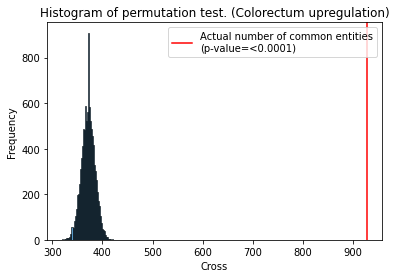

Permutation test (Colorectum downregulation): 100%|██████████| 10000/10000 [00:01<00:00, 5426.61it/s]


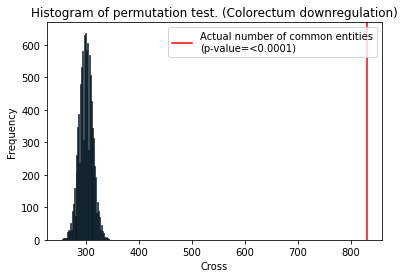

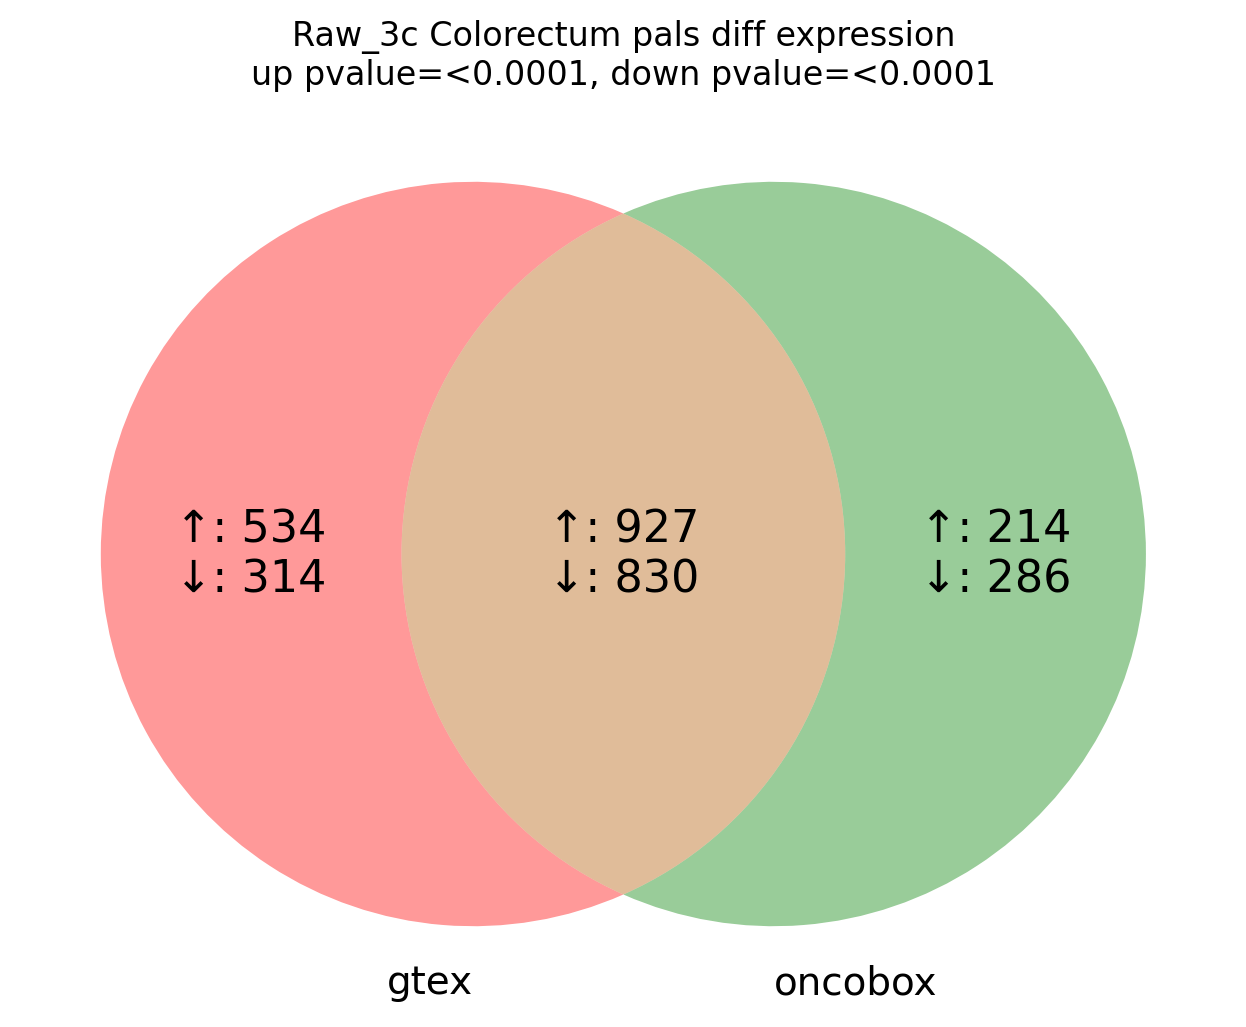

Permutation test (Lung upregulation): 100%|██████████| 10000/10000 [00:01<00:00, 5218.70it/s]


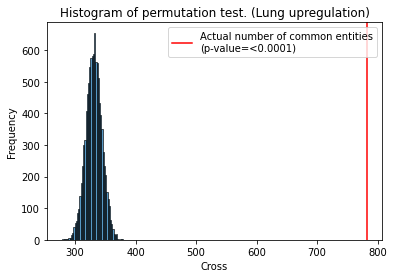

Permutation test (Lung downregulation): 100%|██████████| 10000/10000 [00:01<00:00, 5153.96it/s]


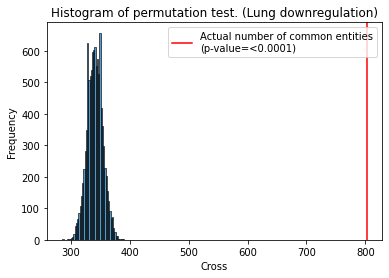

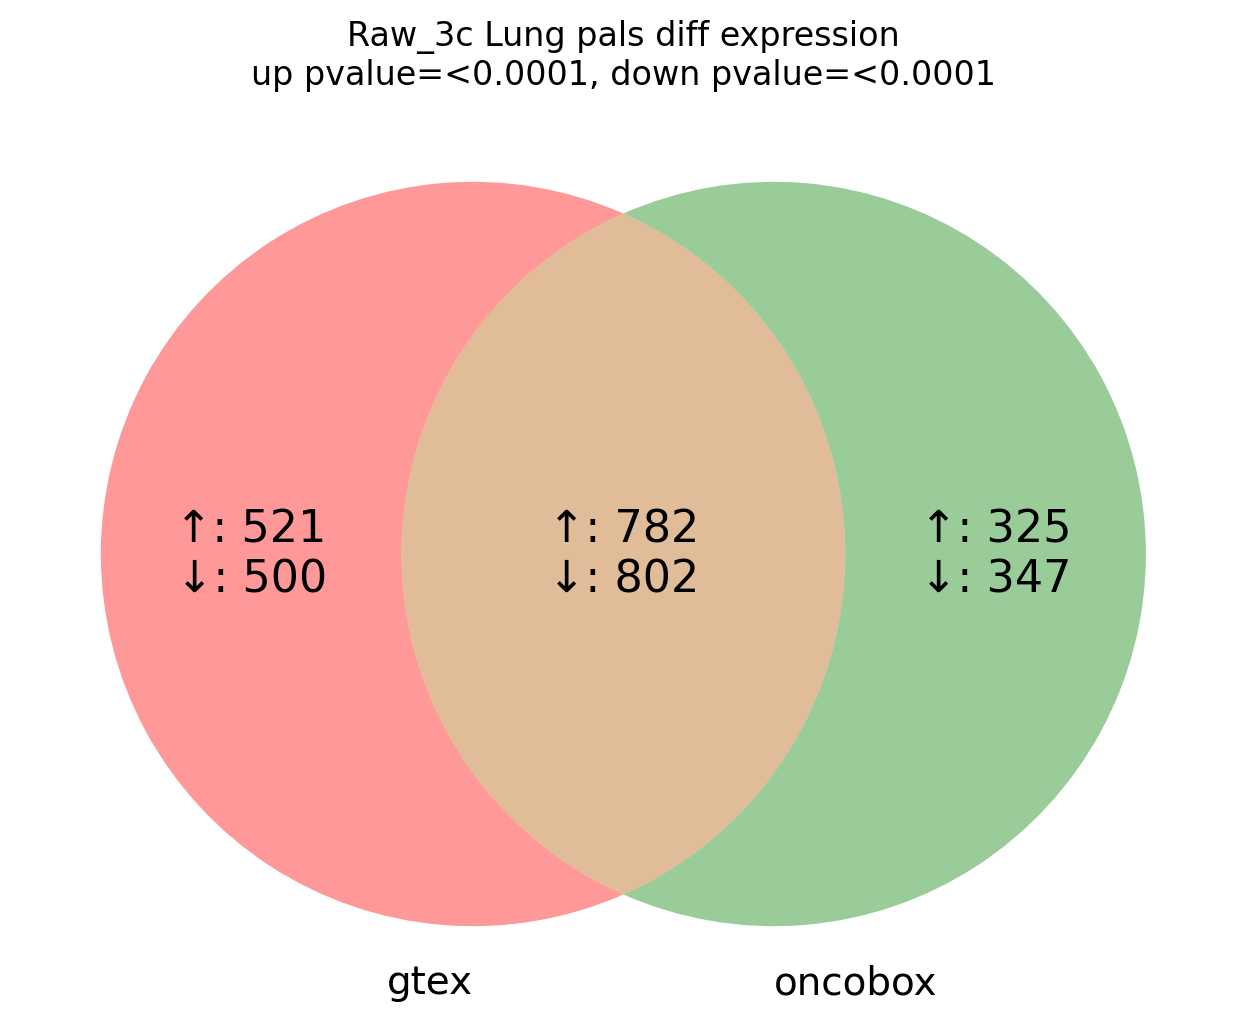

Permutation test (Kidney upregulation): 100%|██████████| 10000/10000 [00:02<00:00, 4999.74it/s]


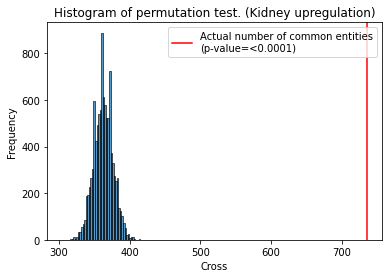

Permutation test (Kidney downregulation): 100%|██████████| 10000/10000 [00:01<00:00, 5476.45it/s]


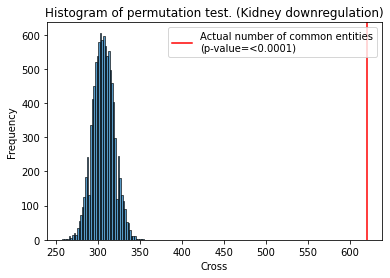

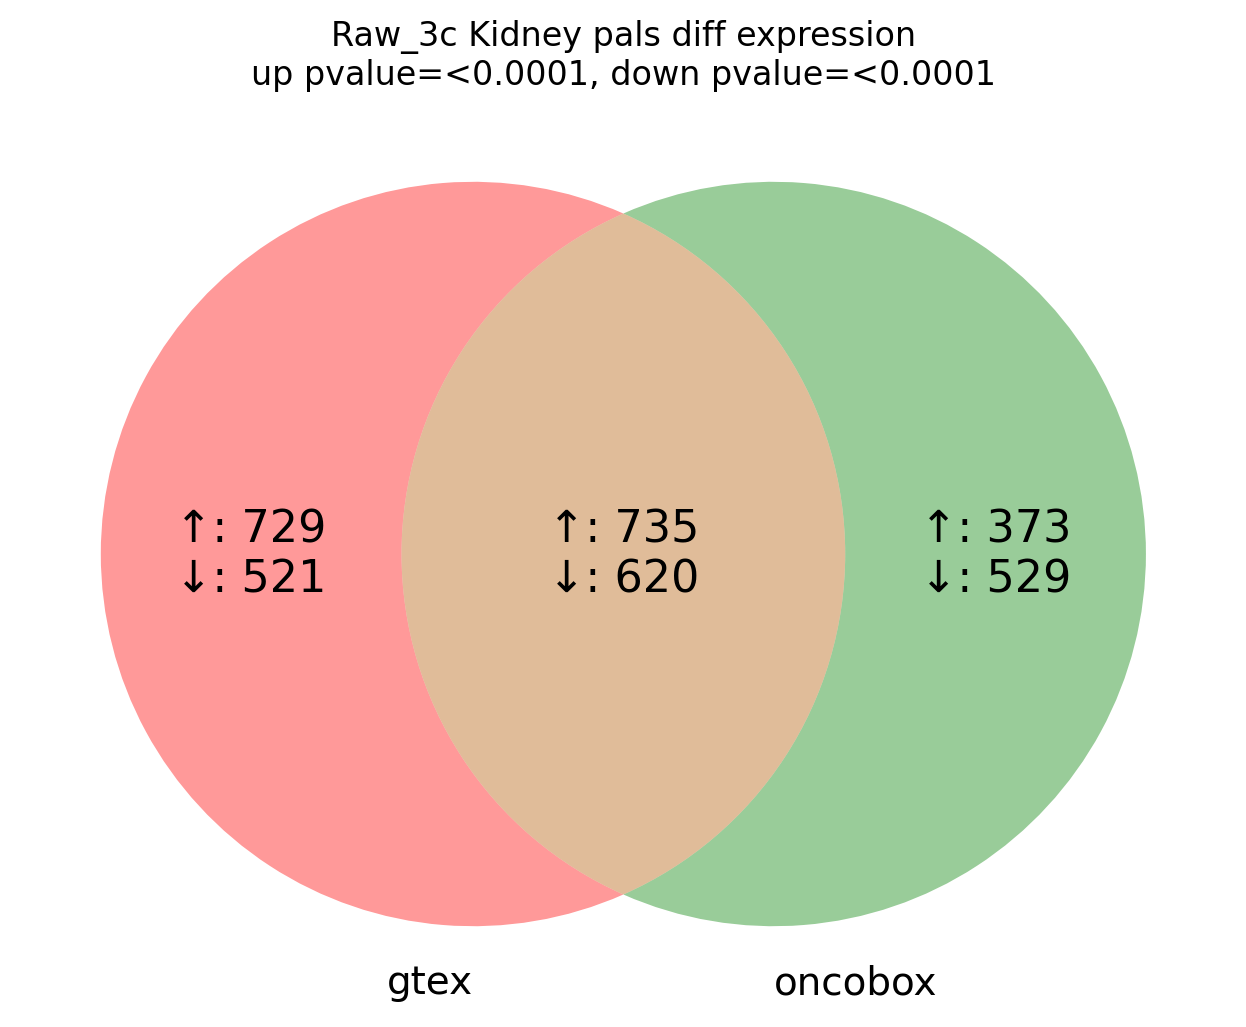

Permutation test (Colorectum upregulation): 100%|██████████| 10000/10000 [00:02<00:00, 4299.09it/s]


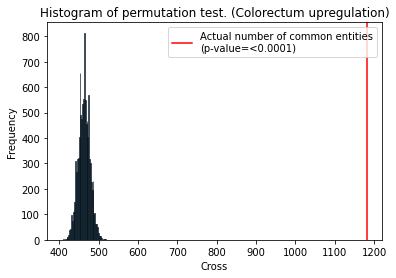

Permutation test (Colorectum downregulation): 100%|██████████| 10000/10000 [00:01<00:00, 6585.58it/s]


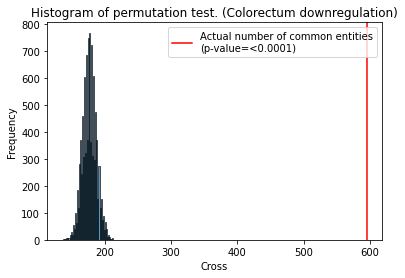

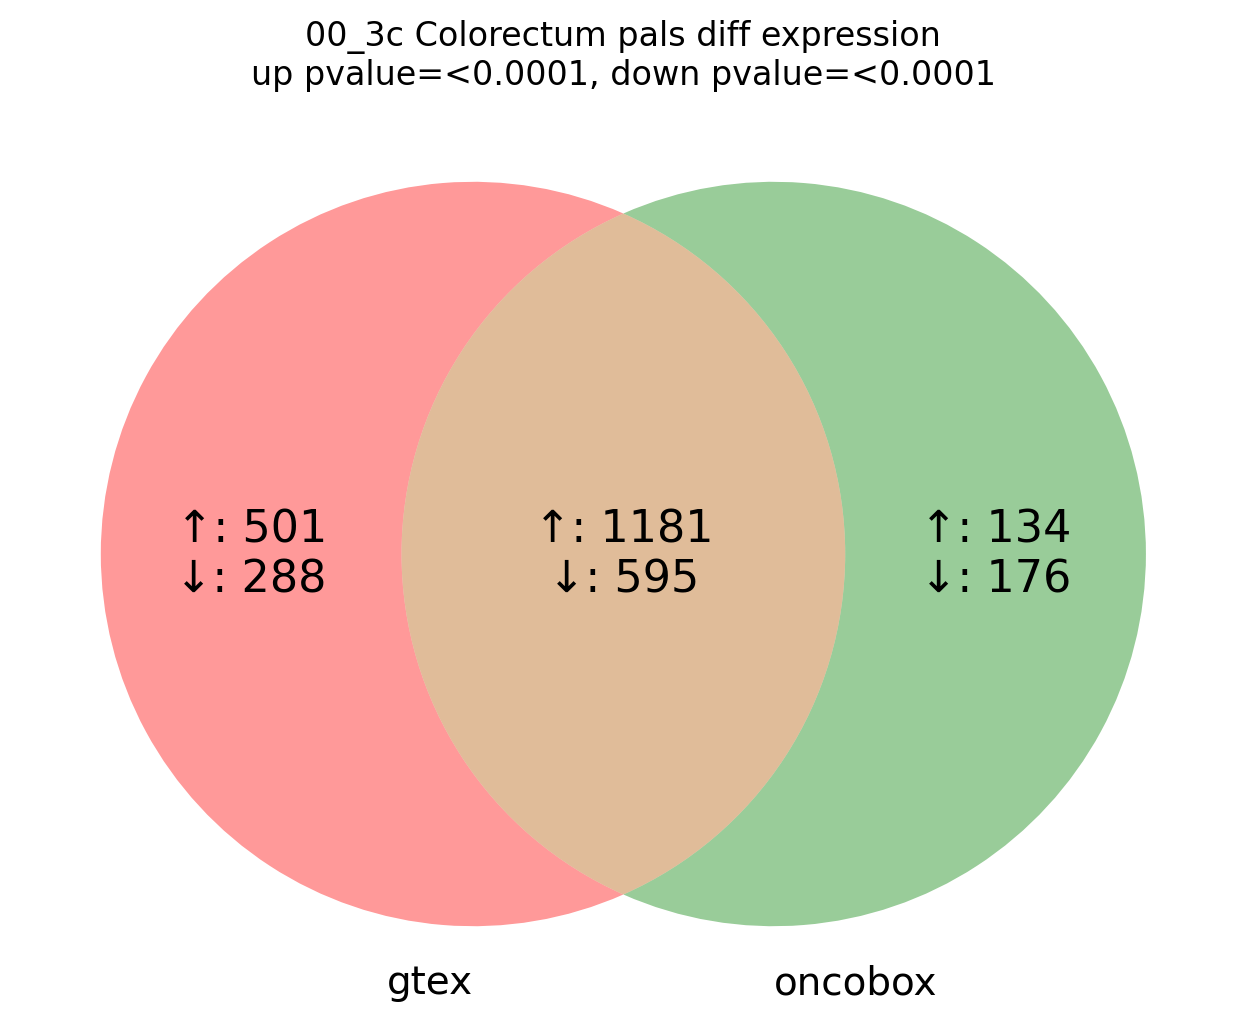

Permutation test (Lung upregulation): 100%|██████████| 10000/10000 [00:02<00:00, 4626.78it/s]


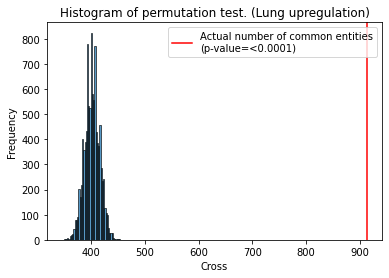

Permutation test (Lung downregulation): 100%|██████████| 10000/10000 [00:01<00:00, 6170.01it/s]


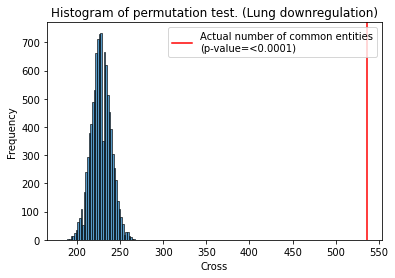

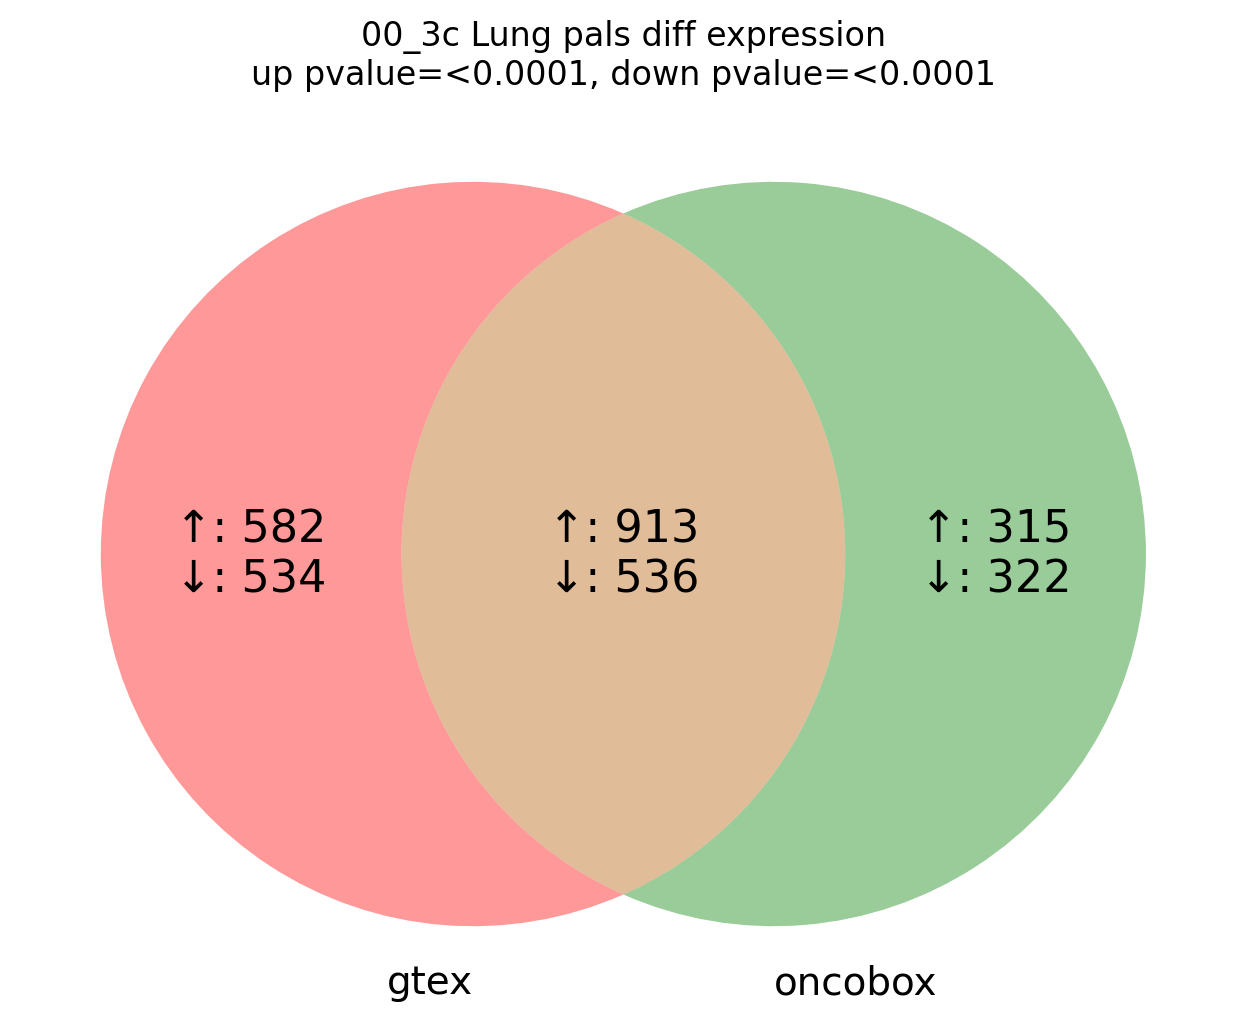

Permutation test (Kidney upregulation): 100%|██████████| 10000/10000 [00:02<00:00, 4466.22it/s]


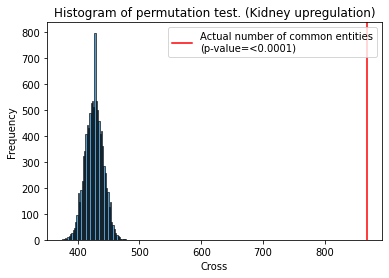

Permutation test (Kidney downregulation): 100%|██████████| 10000/10000 [00:01<00:00, 6215.91it/s]


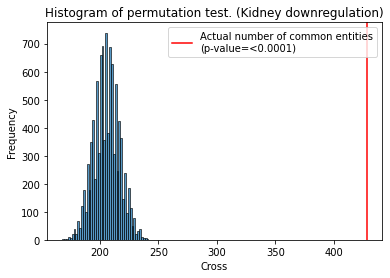

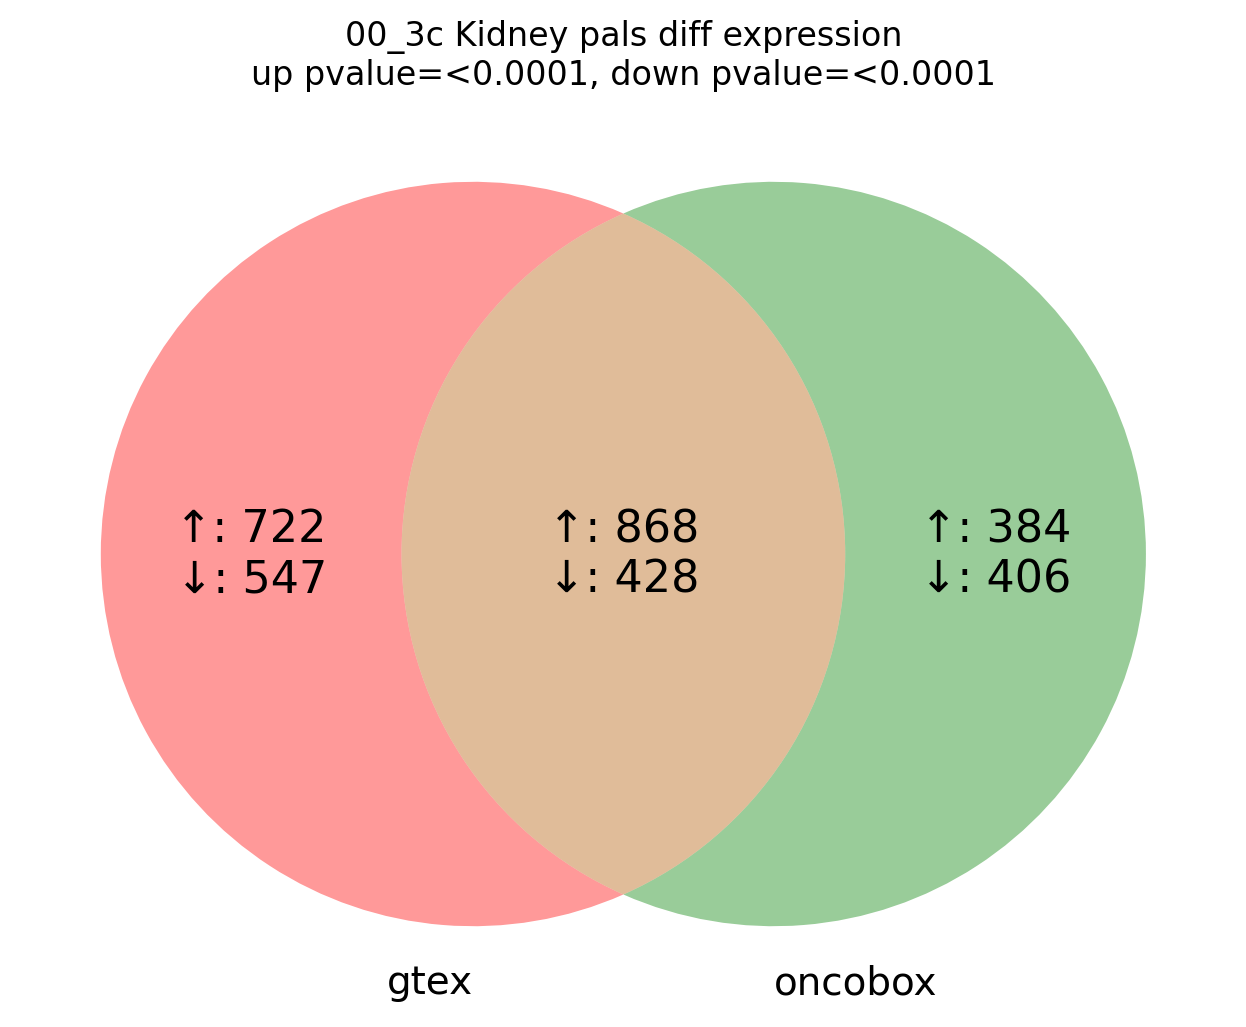

In [8]:
def convert_signal(row):
    if row["fdr_bh"] < 0.05:
        if row["mean_pal"] > 0:
            return 1
        elif row["mean_pal"] < 0:
            return -1
    return 0


dataset_intersections = defaultdict(dict)
all_diff_pals = list()
for dataset_name in DATASET_NAMES:
    gtex_pals = pd.read_csv(
        f"out/shambala/{dataset_name}/{dataset_name}_{'_'.join(['TCGA', 'GTEX'])}_pals.tsv", sep="\t", index_col=0
    )
    oncobox_pals = pd.read_csv(
        f"out/shambala/{dataset_name}/{dataset_name}_{'_'.join(['TCGA', 'Oncobox'])}_pals.tsv", sep="\t", index_col=0
    )
    all_diff_pals.append(pd.concat([gtex_pals, oncobox_pals], axis=1))
    for nosology in NOSOLOGIES:
        matched_norm_samples_ids = ANNO[
            (ANNO.type == nosology) &
            (ANNO.tumor_status == "Normal") &
            (ANNO.plat == "TCGA")
            ].index

        nosology_gtex_pals = pd.concat([
            gtex_pals.filter(matched_norm_samples_ids, axis=1).mean(axis=1),
            gtex_pals["fdr_bh"]
        ], axis=1)
        nosology_gtex_pals.columns = ["mean_pal", "fdr_bh"]
        nosology_gtex_pals_signal = nosology_gtex_pals.apply(convert_signal, axis=1)

        nosology_oncobox_pals = pd.concat([
            oncobox_pals.filter(matched_norm_samples_ids, axis=1).mean(axis=1),
            oncobox_pals["fdr_bh"]
        ], axis=1)
        nosology_oncobox_pals.columns = ["mean_pal", "fdr_bh"]
        nosology_oncobox_pals_signal = nosology_oncobox_pals.apply(convert_signal, axis=1)

        diff_pals = pd.concat([nosology_gtex_pals_signal, nosology_oncobox_pals_signal], axis=1)
        diff_pals.columns = ["gtex", "oncobox"]

        up_lists = [diff_pals[diff_pals.gtex == 1].index, diff_pals[diff_pals.oncobox == 1].index]
        up_intersection, up_pvalue = permutation_test(
            diff_pals.index,
            up_lists, plot=True, group_name=f"{nosology} upregulation"
        )

        down_lists = [diff_pals[diff_pals.gtex == -1].index, diff_pals[diff_pals.oncobox == -1].index]
        down_intersection, down_pvalue = permutation_test(
            diff_pals.index,
            down_lists, plot=True, group_name=f"{nosology} downregulation"
        )
        plot_deg_venn(
            diff_pals,
            title=f"{dataset_name} {nosology} pals diff expression\n"
                  f"up pvalue={'<0.0001' if up_pvalue < .000_1 else round(up_pvalue, 4)}, "
                  f"down pvalue={'<0.0001' if down_pvalue < .000_1 else round(down_pvalue, 4)}",
            out=f"out/shambala/{dataset_name}/venns/nosology_venn.png"
        )
        dataset_intersections[dataset_name][nosology] = dict(up=up_intersection, down=down_intersection)

Permutation test (Colorectum upregulated
Permutation test (Colorectum upregulated 0/10000 [00:00<?, ?it/s]
Permutation test (Colorectum upregulated 554/10000 [00:00<00:01, 5533.49it/s]
Permutation test (Colorectum upregulated 1141/10000 [00:00<00:01, 5726.13it/s]
Permutation test (Colorectum upregulated 1729/10000 [00:00<00:01, 5795.86it/s]
Permutation test (Colorectum upregulated 2309/10000 [00:00<00:01, 5772.56it/s]
Permutation test (Colorectum upregulated 2897/10000 [00:00<00:01, 5809.15it/s]
Permutation test (Colorectum upregulated 3478/10000 [00:00<00:01, 5802.32it/s]
Permutation test (Colorectum upregulated 4060/10000 [00:00<00:01, 5805.52it/s]
Permutation test (Colorectum upregulated 4641/10000 [00:00<00:00, 5617.64it/s]
Permutation test (Colorectum upregulated 5204/10000 [00:00<00:00, 5531.76it/s]
Permutation test (Colorectum upregulated 5759/10000 [00:01<00:00, 5436.83it/s]
Permutation test (Colorectum upregulated 6304/10000 [00:01<00:00, 5425.46it/s]
Permutation test (Colorec

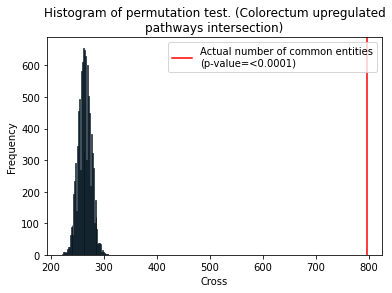

Permutation test (Colorectum downregulated
Permutation test (Colorectum downregulated/10000 [00:00<?, ?it/s]
Permutation test (Colorectum downregulated73/10000 [00:00<00:01, 6725.95it/s]
Permutation test (Colorectum downregulated354/10000 [00:00<00:01, 6772.39it/s]
Permutation test (Colorectum downregulated065/10000 [00:00<00:01, 6923.03it/s]
Permutation test (Colorectum downregulated758/10000 [00:00<00:01, 6494.17it/s]
Permutation test (Colorectum downregulated414/10000 [00:00<00:01, 6514.22it/s]
Permutation test (Colorectum downregulated123/10000 [00:00<00:00, 6704.16it/s]
Permutation test (Colorectum downregulated798/10000 [00:00<00:00, 6716.48it/s]
Permutation test (Colorectum downregulated489/10000 [00:00<00:00, 6774.37it/s]
Permutation test (Colorectum downregulated168/10000 [00:00<00:00, 6722.44it/s]
Permutation test (Colorectum downregulated842/10000 [00:01<00:00, 6708.71it/s]
Permutation test (Colorectum downregulated527/10000 [00:01<00:00, 6750.43it/s]
Permutation test (Color

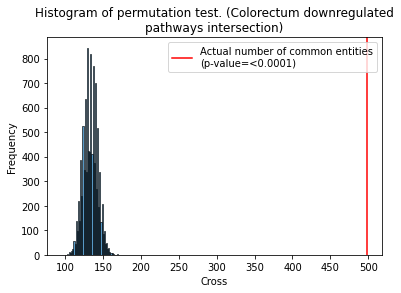

Permutation test (Lung upregulated
Permutation test (Lung upregulated     | 0/10000 [00:00<?, ?it/s]
Permutation test (Lung upregulated     | 566/10000 [00:00<00:01, 5654.37it/s]
Permutation test (Lung upregulated     | 1179/10000 [00:00<00:01, 5929.78it/s]
Permutation test (Lung upregulated     | 1846/10000 [00:00<00:01, 6267.36it/s]
Permutation test (Lung upregulated     | 2513/10000 [00:00<00:01, 6423.50it/s]
Permutation test (Lung upregulated     | 3156/10000 [00:00<00:01, 6396.62it/s]
Permutation test (Lung upregulated     | 3796/10000 [00:00<00:00, 6335.00it/s]
Permutation test (Lung upregulated     | 4430/10000 [00:00<00:00, 6086.50it/s]
Permutation test (Lung upregulated     | 5089/10000 [00:00<00:00, 6238.87it/s]
Permutation test (Lung upregulated▋    | 5745/10000 [00:00<00:00, 6335.59it/s]
Permutation test (Lung upregulated█▍   | 6384/10000 [00:01<00:00, 6350.95it/s]
Permutation test (Lung upregulated██   | 7052/10000 [00:01<00:00, 6448.98it/s]
Permutation test (Lung upregula

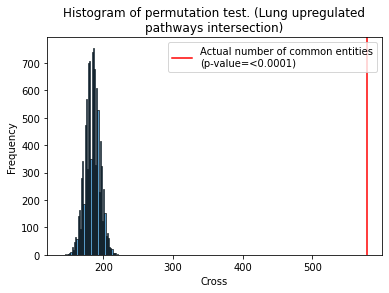

Permutation test (Lung downregulated
Permutation test (Lung downregulated   | 0/10000 [00:00<?, ?it/s]
Permutation test (Lung downregulated   | 660/10000 [00:00<00:01, 6596.69it/s]
Permutation test (Lung downregulated   | 1350/10000 [00:00<00:01, 6770.87it/s]
Permutation test (Lung downregulated   | 2028/10000 [00:00<00:01, 6761.16it/s]
Permutation test (Lung downregulated   | 2768/10000 [00:00<00:01, 7009.91it/s]
Permutation test (Lung downregulated   | 3517/10000 [00:00<00:00, 7182.20it/s]
Permutation test (Lung downregulated   | 4251/10000 [00:00<00:00, 7234.79it/s]
Permutation test (Lung downregulated   | 5011/10000 [00:00<00:00, 7351.00it/s]
Permutation test (Lung downregulated   | 5747/10000 [00:00<00:00, 7305.34it/s]
Permutation test (Lung downregulated   | 6478/10000 [00:00<00:00, 7205.62it/s]
Permutation test (Lung downregulated▏  | 7199/10000 [00:01<00:00, 7107.68it/s]
Permutation test (Lung downregulated▉  | 7911/10000 [00:01<00:00, 6994.54it/s]
Permutation test (Lung downre

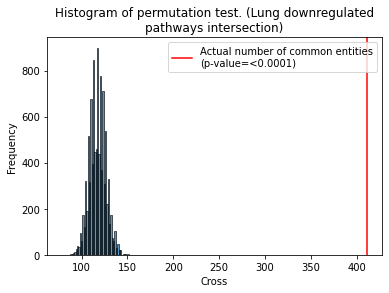

Permutation test (Kidney upregulated
Permutation test (Kidney upregulated   | 0/10000 [00:00<?, ?it/s]
Permutation test (Kidney upregulated   | 691/10000 [00:00<00:01, 6907.88it/s]
Permutation test (Kidney upregulated   | 1382/10000 [00:00<00:01, 6885.73it/s]
Permutation test (Kidney upregulated   | 2071/10000 [00:00<00:01, 6617.40it/s]
Permutation test (Kidney upregulated   | 2734/10000 [00:00<00:01, 6425.16it/s]
Permutation test (Kidney upregulated   | 3378/10000 [00:00<00:01, 6343.59it/s]
Permutation test (Kidney upregulated   | 4039/10000 [00:00<00:00, 6430.35it/s]
Permutation test (Kidney upregulated   | 4718/10000 [00:00<00:00, 6543.37it/s]
Permutation test (Kidney upregulated   | 5393/10000 [00:00<00:00, 6606.13it/s]
Permutation test (Kidney upregulated   | 6063/10000 [00:00<00:00, 6633.57it/s]
Permutation test (Kidney upregulated   | 6735/10000 [00:01<00:00, 6658.48it/s]
Permutation test (Kidney upregulated▍  | 7402/10000 [00:01<00:00, 6621.58it/s]
Permutation test (Kidney upre

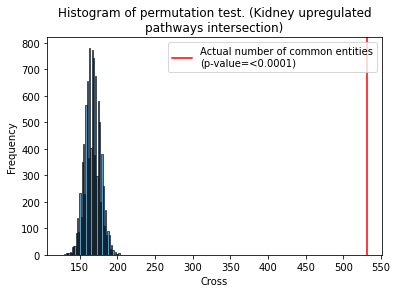

Permutation test (Kidney downregulated
Permutation test (Kidney downregulated | 0/10000 [00:00<?, ?it/s]
Permutation test (Kidney downregulated | 786/10000 [00:00<00:01, 7853.72it/s]
Permutation test (Kidney downregulated | 1572/10000 [00:00<00:01, 7639.66it/s]
Permutation test (Kidney downregulated | 2406/10000 [00:00<00:00, 7951.97it/s]
Permutation test (Kidney downregulated | 3202/10000 [00:00<00:00, 7631.73it/s]
Permutation test (Kidney downregulated | 3968/10000 [00:00<00:00, 7526.52it/s]
Permutation test (Kidney downregulated | 4748/10000 [00:00<00:00, 7614.61it/s]
Permutation test (Kidney downregulated | 5511/10000 [00:00<00:00, 7615.28it/s]
Permutation test (Kidney downregulated | 6291/10000 [00:00<00:00, 7672.79it/s]
Permutation test (Kidney downregulated | 7097/10000 [00:00<00:00, 7789.64it/s]
Permutation test (Kidney downregulated | 7877/10000 [00:01<00:00, 7725.89it/s]
Permutation test (Kidney downregulated | 8753/10000 [00:01<00:00, 8037.59it/s]
Permutation test (Kidney do

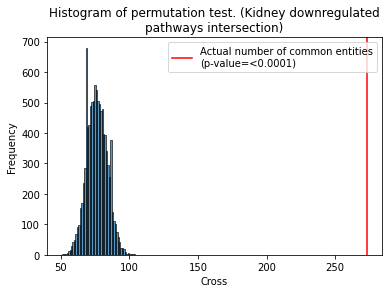

In [10]:
intersections = defaultdict(list)
for nosology in NOSOLOGIES:
    for regulation in ["up", "down"]:
        raw_dataset_regulations = dataset_intersections[RAW_DATASET_NAME][nosology][regulation]
        shambalized_dataset_regulations = dataset_intersections[SHAMBALIZED_DATASET_NAME][nosology][regulation]
        curr_intersection, pvalue = permutation_test(
            all_diff_pals[0].index,
            [raw_dataset_regulations, shambalized_dataset_regulations],
            plot=True, group_name=f"{nosology} {regulation}regulated\n"
                                  f"pathways intersection"
        )
        intersections[regulation].append(curr_intersection)

/tmp/ipykernel_14726/1762890225.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean_diff_pal = pd.concat(all_diff_pals).mean(axis=1).to_dict()
Permutation test (Intersection of upregulation
Permutation test (Intersection of upregulation%|          | 0/10000 [00:00<?, ?it/s]
Permutation test (Intersection of upregulation%|▌         | 547/10000 [00:00<00:01, 5465.18it/s]
Permutation test (Intersection of upregulation%|█         | 1094/10000 [00:00<00:01, 5387.30it/s]
Permutation test (Intersection of upregulation%|█▋        | 1641/10000 [00:00<00:01, 5421.90it/s]
Permutation test (Intersection of upregulation%|██▏       | 2187/10000 [00:00<00:01, 5435.56it/s]
Permutation test (Intersection of upregulation%|██▋       | 2732/10000 [00:00<00:01, 5437.80it/s]
Permutation test (Intersection of upregulation%|███▎      | 3

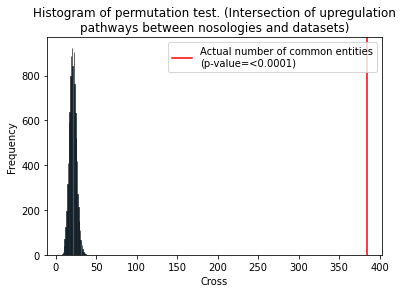

Permutation test (Intersection of downregulation
Permutation test (Intersection of downregulation          | 0/10000 [00:00<?, ?it/s]
Permutation test (Intersection of downregulation▌         | 590/10000 [00:00<00:01, 5891.52it/s]
Permutation test (Intersection of downregulation█▏        | 1183/10000 [00:00<00:01, 5910.25it/s]
Permutation test (Intersection of downregulation█▊        | 1775/10000 [00:00<00:01, 5878.98it/s]
Permutation test (Intersection of downregulation██▎       | 2363/10000 [00:00<00:01, 5877.91it/s]
Permutation test (Intersection of downregulation██▉       | 2992/10000 [00:00<00:01, 6023.09it/s]
Permutation test (Intersection of downregulation███▌      | 3618/10000 [00:00<00:01, 6102.61it/s]
Permutation test (Intersection of downregulation████▏     | 4236/10000 [00:00<00:00, 6127.28it/s]
Permutation test (Intersection of downregulation████▉     | 4877/10000 [00:00<00:00, 6214.60it/s]
Permutation test (Intersection of downregulation█████▍    | 5499/10000 [00:00<00:00

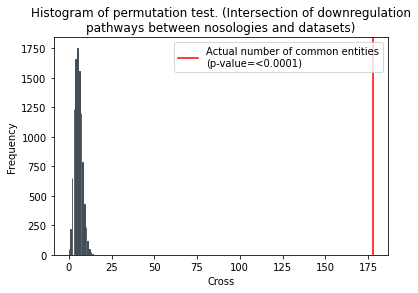

In [13]:
mean_diff_pal = pd.concat(all_diff_pals).mean(axis=1).to_dict()

for regulation in ["up", "down"]:
    intersection, _ = permutation_test(
        all_diff_pals[0].index,
        intersections[regulation], plot=True,
        group_name=f"Intersection of {regulation}regulation\n"
                   f"pathways between nosologies and datasets"
    )
    with open(f"out/shambala/final_pals_{regulation}.txt", "w") as f:
        for pathway in intersection:
            f.write(f"{pathway}\t{mean_diff_pal[pathway]}\n")